In [1]:
# Enable hot reloading 
%load_ext autoreload
%autoreload 2


In [2]:
# Set cuda device for this notebook 
import torch 
torch.cuda.set_device(0)

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from utils import get_class_map, seed_everything, multi_class_balance_classes, get_imagenet_dataloader, get_imagenet_whole_dataloader
from model import get_model, WrapMultiClassifier, split_model
from converter import PredictionConverter

/home/hengl/miniforge3/envs/deit/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Seed
seed_everything(42)

# Get dataloader
dataloader = get_imagenet_dataloader(is_val=True, sub_set=True, sample_number=200, seed=3407)
# dataloader = get_imagenet_whole_dataloader()
print(f"Length of dataloader: {len(dataloader)}")

# Get class map
folder_map, zip_map = get_class_map()

# Init a PredictionConverter 
converter = PredictionConverter(folder_map, zip_map)

# Create a class_map for zip_train 
class_map = converter.batch_convert(list(range(1000)), reverse=True)
print(f"class_map: {class_map}")


Creating subset: 100%|██████████| 1000/1000 [01:15<00:00, 13.23it/s]


Length of dataloader: 98
class_map: [538, 735, 432, 61, 458, 233, 188, 549, 354, 625, 864, 388, 254, 387, 216, 221, 190, 356, 168, 749, 917, 59, 201, 253, 687, 797, 750, 162, 250, 940, 313, 22, 501, 589, 585, 528, 132, 629, 315, 17, 835, 886, 725, 67, 701, 125, 531, 220, 678, 729, 852, 178, 812, 920, 333, 446, 682, 784, 431, 219, 223, 895, 425, 825, 176, 1, 728, 106, 804, 699, 428, 4, 353, 323, 68, 995, 39, 492, 570, 901, 456, 329, 319, 891, 124, 422, 69, 801, 118, 724, 859, 748, 692, 208, 900, 299, 898, 383, 415, 505, 640, 2, 101, 177, 366, 903, 524, 540, 823, 361, 965, 595, 232, 741, 112, 307, 828, 481, 127, 157, 863, 753, 854, 138, 800, 537, 557, 379, 50, 577, 763, 877, 416, 60, 787, 483, 850, 511, 350, 185, 207, 686, 468, 141, 260, 966, 990, 283, 588, 6, 96, 91, 974, 882, 48, 764, 459, 869, 637, 671, 495, 981, 924, 727, 946, 685, 809, 166, 609, 100, 902, 267, 987, 391, 152, 513, 268, 355, 81, 747, 36, 696, 672, 180, 121, 332, 234, 386, 54, 466, 46, 129, 929, 584, 810, 49, 867, 243,

In [5]:
# Get model 
checkpoint_path = "/home/hengl/lbsm/vis/deit_small_top2zc-top2zn_non-weighted_cls_token_xe_no_ls_best.pth"
zip_train = [False, True]
pretrained_model, our_model = get_model('deit_small_patch16_224', checkpoint_path=checkpoint_path, qkv_bias=False, zip_train=zip_train, class_map=[None, class_map])
feature_extractor, classifier = split_model(our_model)
pretrained_feature_extractor, pretrained_classifier = split_model(pretrained_model)


/home/hengl/lbsm/vis/model.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [6]:
_, no_ls_model = get_model('deit_small_patch16_224', checkpoint_path='/home/hengl/lbsm/vis/best_checkpoint_no_ls_no_cache.pth', qkv_bias=False, zip_train=[False, False], class_map=[None, None])
_, no_ls_classifier = split_model(no_ls_model)

# Some Exploration

In [7]:
from explore import calculate_accuracy_by_class, list_differences_and_count_zeros

In [8]:
our_model

WrapForwardModel(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
   

In [9]:
# # try to load features 
# fix = 'features_'
# X_our = np.load(f'/datadrive2/hengl/lbsm/vis/{fix}ours_features.npy')
# y_our = np.load(f'/datadrive2/hengl/lbsm/vis/{fix}ours_labels.npy')
# X_pretrained = np.load(f'/datadrive2/hengl/lbsm/vis/{fix}pretrained_features.npy')
# y_pretrained = np.load(f'/datadrive2/hengl/lbsm/vis/{fix}pretrained_labels.npy')
# X_nols = np.load(f'/datadrive2/hengl/lbsm/vis/{fix}no_ls_features.npy')
# y_nols = np.load(f'/datadrive2/hengl/lbsm/vis/{fix}no_ls_labels.npy')

In [10]:
!ls /datadrive2/hengl/lbsm/vis

features		     features_ours_labels.npy
features_no_ls_features.npy  features_pretrained_features.npy
features_no_ls_labels.npy    features_pretrained_labels.npy
features_ours_features.npy


In [11]:
our_accuracy_per_class, X_our, y_our = calculate_accuracy_by_class(our_model, dataloader, 1000)

Evaluating:   1%|          | 1/98 [00:33<53:21, 33.00s/it]

Accuracy: 0.9468


Evaluating:   2%|▏         | 2/98 [00:34<23:26, 14.65s/it]

Accuracy: 0.8916


Evaluating:   3%|▎         | 3/98 [00:36<13:52,  8.76s/it]

Accuracy: 0.9492


Evaluating:   4%|▍         | 4/98 [00:38<09:22,  5.99s/it]

Accuracy: 0.9517


Evaluating:   5%|▌         | 5/98 [00:40<06:54,  4.45s/it]

Accuracy: 0.8755


Evaluating:   6%|▌         | 6/98 [00:41<05:25,  3.54s/it]

Accuracy: 0.9082


Evaluating:   7%|▋         | 7/98 [00:43<04:28,  2.95s/it]

Accuracy: 0.8828


Evaluating:   8%|▊         | 8/98 [00:45<03:51,  2.57s/it]

Accuracy: 0.9438


Evaluating:   9%|▉         | 9/98 [00:47<03:25,  2.31s/it]

Accuracy: 0.9214


Evaluating:  10%|█         | 10/98 [00:48<03:08,  2.15s/it]

Accuracy: 0.9351


Evaluating:  11%|█         | 11/98 [00:50<02:56,  2.03s/it]

Accuracy: 0.9077


Evaluating:  12%|█▏        | 12/98 [00:52<02:48,  1.96s/it]

Accuracy: 0.8999


Evaluating:  13%|█▎        | 13/98 [00:54<02:41,  1.90s/it]

Accuracy: 0.8936


Evaluating:  14%|█▍        | 14/98 [00:55<02:34,  1.84s/it]

Accuracy: 0.9316


Evaluating:  15%|█▌        | 15/98 [00:57<02:30,  1.81s/it]

Accuracy: 0.9136


Evaluating:  16%|█▋        | 16/98 [00:59<02:27,  1.80s/it]

Accuracy: 0.8804


Evaluating:  17%|█▋        | 17/98 [01:01<02:26,  1.80s/it]

Accuracy: 0.8882


Evaluating:  18%|█▊        | 18/98 [01:02<02:23,  1.80s/it]

Accuracy: 0.9077


Evaluating:  19%|█▉        | 19/98 [01:04<02:21,  1.79s/it]

Accuracy: 0.9009


Evaluating:  20%|██        | 20/98 [01:06<02:19,  1.78s/it]

Accuracy: 0.9053


Evaluating:  21%|██▏       | 21/98 [01:08<02:16,  1.77s/it]

Accuracy: 0.8906


Evaluating:  22%|██▏       | 22/98 [01:10<02:23,  1.89s/it]

Accuracy: 0.8955


Evaluating:  22%|██▏       | 22/98 [01:12<02:23,  1.89s/it]

Accuracy: 0.9146


Evaluating:  24%|██▍       | 24/98 [01:14<02:18,  1.87s/it]

Accuracy: 0.9028


Evaluating:  26%|██▌       | 25/98 [01:15<02:13,  1.84s/it]

Accuracy: 0.8970


Evaluating:  27%|██▋       | 26/98 [01:17<02:11,  1.83s/it]

Accuracy: 0.9370


Evaluating:  28%|██▊       | 27/98 [01:19<02:08,  1.82s/it]

Accuracy: 0.8394


Evaluating:  29%|██▊       | 28/98 [01:21<02:06,  1.81s/it]

Accuracy: 0.7856


Evaluating:  30%|██▉       | 29/98 [01:23<02:04,  1.80s/it]

Accuracy: 0.7988


Evaluating:  31%|███       | 30/98 [01:24<02:00,  1.78s/it]

Accuracy: 0.7900


Evaluating:  32%|███▏      | 31/98 [01:26<01:58,  1.77s/it]

Accuracy: 0.9009


Evaluating:  33%|███▎      | 32/98 [01:28<01:56,  1.77s/it]

Accuracy: 0.9409


Evaluating:  34%|███▎      | 33/98 [01:30<01:55,  1.77s/it]

Accuracy: 0.8882


Evaluating:  35%|███▍      | 34/98 [01:31<01:53,  1.77s/it]

Accuracy: 0.8599


Evaluating:  36%|███▌      | 35/98 [01:33<01:51,  1.77s/it]

Accuracy: 0.9360


Evaluating:  37%|███▋      | 36/98 [01:35<01:50,  1.78s/it]

Accuracy: 0.8906


Evaluating:  38%|███▊      | 37/98 [01:37<01:48,  1.77s/it]

Accuracy: 0.7607


Evaluating:  39%|███▉      | 38/98 [01:39<01:46,  1.77s/it]

Accuracy: 0.8145


Evaluating:  40%|███▉      | 39/98 [01:40<01:43,  1.76s/it]

Accuracy: 0.8184


Evaluating:  41%|████      | 40/98 [01:42<01:41,  1.74s/it]

Accuracy: 0.8428


Evaluating:  42%|████▏     | 41/98 [01:44<01:39,  1.74s/it]

Accuracy: 0.8647


Evaluating:  43%|████▎     | 42/98 [01:45<01:38,  1.76s/it]

Accuracy: 0.8271


Evaluating:  44%|████▍     | 43/98 [01:47<01:37,  1.77s/it]

Accuracy: 0.7886


Evaluating:  45%|████▍     | 44/98 [01:49<01:35,  1.78s/it]

Accuracy: 0.8740


Evaluating:  46%|████▌     | 45/98 [01:51<01:33,  1.77s/it]

Accuracy: 0.8398


Evaluating:  47%|████▋     | 46/98 [01:53<01:31,  1.75s/it]

Accuracy: 0.8354


Evaluating:  48%|████▊     | 47/98 [01:54<01:29,  1.76s/it]

Accuracy: 0.8711


Evaluating:  49%|████▉     | 48/98 [01:56<01:28,  1.77s/it]

Accuracy: 0.8555


Evaluating:  50%|█████     | 49/98 [01:58<01:27,  1.79s/it]

Accuracy: 0.9175


Evaluating:  51%|█████     | 50/98 [02:00<01:26,  1.79s/it]

Accuracy: 0.8521


Evaluating:  52%|█████▏    | 51/98 [02:02<01:23,  1.79s/it]

Accuracy: 0.8301


Evaluating:  53%|█████▎    | 52/98 [02:03<01:21,  1.78s/it]

Accuracy: 0.8599


Evaluating:  54%|█████▍    | 53/98 [02:05<01:19,  1.78s/it]

Accuracy: 0.7881


Evaluating:  55%|█████▌    | 54/98 [02:07<01:18,  1.78s/it]

Accuracy: 0.8398


Evaluating:  56%|█████▌    | 55/98 [02:09<01:16,  1.77s/it]

Accuracy: 0.7397


Evaluating:  57%|█████▋    | 56/98 [02:10<01:13,  1.76s/it]

Accuracy: 0.8110


Evaluating:  58%|█████▊    | 57/98 [02:12<01:12,  1.76s/it]

Accuracy: 0.7881


Evaluating:  59%|█████▉    | 58/98 [02:14<01:11,  1.79s/it]

Accuracy: 0.8057


Evaluating:  60%|██████    | 59/98 [02:16<01:10,  1.80s/it]

Accuracy: 0.7168


Evaluating:  61%|██████    | 60/98 [02:18<01:08,  1.81s/it]

Accuracy: 0.7168


Evaluating:  62%|██████▏   | 61/98 [02:19<01:06,  1.80s/it]

Accuracy: 0.7397


Evaluating:  63%|██████▎   | 62/98 [02:21<01:04,  1.78s/it]

Accuracy: 0.7314


Evaluating:  64%|██████▍   | 63/98 [02:23<01:02,  1.78s/it]

Accuracy: 0.7095


Evaluating:  65%|██████▌   | 64/98 [02:25<01:00,  1.79s/it]

Accuracy: 0.7695


Evaluating:  66%|██████▋   | 65/98 [02:27<00:59,  1.80s/it]

Accuracy: 0.8062


Evaluating:  67%|██████▋   | 66/98 [02:28<00:57,  1.79s/it]

Accuracy: 0.8267


Evaluating:  68%|██████▊   | 67/98 [02:30<00:55,  1.79s/it]

Accuracy: 0.8647


Evaluating:  69%|██████▉   | 68/98 [02:32<00:53,  1.79s/it]

Accuracy: 0.7671


Evaluating:  70%|███████   | 69/98 [02:34<00:51,  1.79s/it]

Accuracy: 0.8047


Evaluating:  71%|███████▏  | 70/98 [02:35<00:50,  1.80s/it]

Accuracy: 0.7612


Evaluating:  72%|███████▏  | 71/98 [02:37<00:47,  1.78s/it]

Accuracy: 0.7402


Evaluating:  73%|███████▎  | 72/98 [02:39<00:45,  1.76s/it]

Accuracy: 0.7480


Evaluating:  74%|███████▍  | 73/98 [02:41<00:43,  1.76s/it]

Accuracy: 0.7231


Evaluating:  76%|███████▌  | 74/98 [02:42<00:42,  1.77s/it]

Accuracy: 0.7705


Evaluating:  77%|███████▋  | 75/98 [02:44<00:40,  1.77s/it]

Accuracy: 0.7612


Evaluating:  78%|███████▊  | 76/98 [02:46<00:39,  1.78s/it]

Accuracy: 0.7905


Evaluating:  79%|███████▊  | 77/98 [02:48<00:37,  1.78s/it]

Accuracy: 0.7842


Evaluating:  80%|███████▉  | 78/98 [02:50<00:35,  1.77s/it]

Accuracy: 0.8047


Evaluating:  81%|████████  | 79/98 [02:51<00:33,  1.78s/it]

Accuracy: 0.7207


Evaluating:  82%|████████▏ | 80/98 [02:53<00:31,  1.78s/it]

Accuracy: 0.7896


Evaluating:  83%|████████▎ | 81/98 [02:55<00:30,  1.78s/it]

Accuracy: 0.7900


Evaluating:  84%|████████▎ | 82/98 [02:57<00:28,  1.77s/it]

Accuracy: 0.7583


Evaluating:  85%|████████▍ | 83/98 [02:58<00:26,  1.77s/it]

Accuracy: 0.7866


Evaluating:  86%|████████▌ | 84/98 [03:00<00:24,  1.78s/it]

Accuracy: 0.7617


Evaluating:  87%|████████▋ | 85/98 [03:02<00:23,  1.78s/it]

Accuracy: 0.7759


Evaluating:  88%|████████▊ | 86/98 [03:04<00:21,  1.79s/it]

Accuracy: 0.6992


Evaluating:  89%|████████▉ | 87/98 [03:06<00:19,  1.78s/it]

Accuracy: 0.7231


Evaluating:  90%|████████▉ | 88/98 [03:07<00:17,  1.76s/it]

Accuracy: 0.7734


Evaluating:  91%|█████████ | 89/98 [03:09<00:15,  1.76s/it]

Accuracy: 0.7886


Evaluating:  92%|█████████▏| 90/98 [03:11<00:14,  1.78s/it]

Accuracy: 0.7559


Evaluating:  93%|█████████▎| 91/98 [03:13<00:12,  1.79s/it]

Accuracy: 0.6963


Evaluating:  94%|█████████▍| 92/98 [03:15<00:10,  1.79s/it]

Accuracy: 0.7930


Evaluating:  95%|█████████▍| 93/98 [03:16<00:08,  1.79s/it]

Accuracy: 0.7793


Evaluating:  96%|█████████▌| 94/98 [03:18<00:07,  1.77s/it]

Accuracy: 0.8276


Evaluating:  97%|█████████▋| 95/98 [03:20<00:05,  1.77s/it]

Accuracy: 0.8647


Evaluating:  98%|█████████▊| 96/98 [03:22<00:03,  1.77s/it]

Accuracy: 0.7085


Evaluating:  99%|█████████▉| 97/98 [03:23<00:01,  1.79s/it]

Accuracy: 0.8501


Evaluating: 100%|██████████| 98/98 [03:25<00:00,  1.63s/it]

Accuracy: 0.8043


Evaluating: 100%|██████████| 98/98 [03:25<00:00,  2.10s/it]


In [12]:
no_ls_accuracy_per_class, X_nols, y_nols = calculate_accuracy_by_class(no_ls_model, dataloader, 1000)

Evaluating:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   1%|          | 1/98 [00:16<25:57, 16.06s/it]

Accuracy: 0.9419


Evaluating:   2%|▏         | 2/98 [00:17<12:14,  7.65s/it]

Accuracy: 0.8877


Evaluating:   3%|▎         | 3/98 [00:19<07:52,  4.97s/it]

Accuracy: 0.9463


Evaluating:   4%|▍         | 4/98 [00:21<05:48,  3.71s/it]

Accuracy: 0.9429


Evaluating:   5%|▌         | 5/98 [00:23<04:40,  3.02s/it]

Accuracy: 0.8774


Evaluating:   6%|▌         | 6/98 [00:24<03:59,  2.61s/it]

Accuracy: 0.8984


Evaluating:   7%|▋         | 7/98 [00:26<03:32,  2.34s/it]

Accuracy: 0.8789


Evaluating:   8%|▊         | 8/98 [00:28<03:13,  2.15s/it]

Accuracy: 0.9409


Evaluating:   9%|▉         | 9/98 [00:30<03:03,  2.06s/it]

Accuracy: 0.9229


Evaluating:  10%|█         | 10/98 [00:32<02:53,  1.98s/it]

Accuracy: 0.9282


Evaluating:  11%|█         | 11/98 [00:33<02:46,  1.91s/it]

Accuracy: 0.9082


Evaluating:  12%|█▏        | 12/98 [00:35<02:40,  1.86s/it]

Accuracy: 0.8950


Evaluating:  13%|█▎        | 13/98 [00:37<02:35,  1.83s/it]

Accuracy: 0.8931


Evaluating:  14%|█▍        | 14/98 [00:39<02:31,  1.80s/it]

Accuracy: 0.9268


Evaluating:  15%|█▌        | 15/98 [00:40<02:27,  1.78s/it]

Accuracy: 0.9160


Evaluating:  16%|█▋        | 16/98 [00:42<02:24,  1.77s/it]

Accuracy: 0.8838


Evaluating:  17%|█▋        | 17/98 [00:44<02:22,  1.76s/it]

Accuracy: 0.8921


Evaluating:  18%|█▊        | 18/98 [00:46<02:22,  1.78s/it]

Accuracy: 0.8950


Evaluating:  19%|█▉        | 19/98 [00:47<02:19,  1.77s/it]

Accuracy: 0.8965


Evaluating:  20%|██        | 20/98 [00:49<02:17,  1.76s/it]

Accuracy: 0.8984


Evaluating:  21%|██▏       | 21/98 [00:51<02:16,  1.78s/it]

Accuracy: 0.8892


Evaluating:  22%|██▏       | 22/98 [00:53<02:15,  1.78s/it]

Accuracy: 0.8901


Evaluating:  23%|██▎       | 23/98 [00:55<02:13,  1.78s/it]

Accuracy: 0.9111


Evaluating:  24%|██▍       | 24/98 [00:56<02:11,  1.77s/it]

Accuracy: 0.9048


Evaluating:  26%|██▌       | 25/98 [00:58<02:10,  1.78s/it]

Accuracy: 0.8921


Evaluating:  27%|██▋       | 26/98 [01:00<02:08,  1.78s/it]

Accuracy: 0.9424


Evaluating:  28%|██▊       | 27/98 [01:02<02:06,  1.78s/it]

Accuracy: 0.8384


Evaluating:  29%|██▊       | 28/98 [01:03<02:03,  1.76s/it]

Accuracy: 0.7910


Evaluating:  30%|██▉       | 29/98 [01:05<02:00,  1.75s/it]

Accuracy: 0.7900


Evaluating:  31%|███       | 30/98 [01:07<01:58,  1.74s/it]

Accuracy: 0.7788


Evaluating:  32%|███▏      | 31/98 [01:09<01:56,  1.74s/it]

Accuracy: 0.9087


Evaluating:  33%|███▎      | 32/98 [01:10<01:54,  1.74s/it]

Accuracy: 0.9233


Evaluating:  34%|███▎      | 33/98 [01:12<01:53,  1.75s/it]

Accuracy: 0.8921


Evaluating:  35%|███▍      | 34/98 [01:14<01:52,  1.76s/it]

Accuracy: 0.8594


Evaluating:  35%|███▍      | 34/98 [01:16<01:52,  1.76s/it]

Accuracy: 0.9375


Evaluating:  37%|███▋      | 36/98 [01:18<01:54,  1.85s/it]

Accuracy: 0.8755


Evaluating:  38%|███▊      | 37/98 [01:20<01:51,  1.83s/it]

Accuracy: 0.7407


Evaluating:  39%|███▉      | 38/98 [01:21<01:49,  1.82s/it]

Accuracy: 0.8232


Evaluating:  40%|███▉      | 39/98 [01:23<01:46,  1.80s/it]

Accuracy: 0.7900


Evaluating:  41%|████      | 40/98 [01:25<01:43,  1.79s/it]

Accuracy: 0.8311


Evaluating:  42%|████▏     | 41/98 [01:27<01:42,  1.79s/it]

Accuracy: 0.8677


Evaluating:  43%|████▎     | 42/98 [01:29<01:41,  1.81s/it]

Accuracy: 0.8301


Evaluating:  44%|████▍     | 43/98 [01:30<01:38,  1.79s/it]

Accuracy: 0.7925


Evaluating:  45%|████▍     | 44/98 [01:32<01:36,  1.80s/it]

Accuracy: 0.8721


Evaluating:  46%|████▌     | 45/98 [01:34<01:36,  1.82s/it]

Accuracy: 0.8267


Evaluating:  47%|████▋     | 46/98 [01:36<01:34,  1.81s/it]

Accuracy: 0.8467


Evaluating:  48%|████▊     | 47/98 [01:38<01:31,  1.79s/it]

Accuracy: 0.8379


Evaluating:  49%|████▉     | 48/98 [01:39<01:29,  1.78s/it]

Accuracy: 0.8604


Evaluating:  50%|█████     | 49/98 [01:41<01:27,  1.79s/it]

Accuracy: 0.9297


Evaluating:  51%|█████     | 50/98 [01:43<01:25,  1.78s/it]

Accuracy: 0.8589


Evaluating:  52%|█████▏    | 51/98 [01:45<01:23,  1.79s/it]

Accuracy: 0.8418


Evaluating:  53%|█████▎    | 52/98 [01:46<01:21,  1.78s/it]

Accuracy: 0.8633


Evaluating:  54%|█████▍    | 53/98 [01:48<01:20,  1.79s/it]

Accuracy: 0.7896


Evaluating:  55%|█████▌    | 54/98 [01:50<01:19,  1.80s/it]

Accuracy: 0.8394


Evaluating:  56%|█████▌    | 55/98 [01:52<01:17,  1.79s/it]

Accuracy: 0.7378


Evaluating:  57%|█████▋    | 56/98 [01:54<01:15,  1.80s/it]

Accuracy: 0.8018


Evaluating:  58%|█████▊    | 57/98 [01:55<01:13,  1.80s/it]

Accuracy: 0.7627


Evaluating:  59%|█████▉    | 58/98 [01:57<01:12,  1.81s/it]

Accuracy: 0.7686


Evaluating:  60%|██████    | 59/98 [01:59<01:10,  1.80s/it]

Accuracy: 0.7222


Evaluating:  61%|██████    | 60/98 [02:01<01:07,  1.78s/it]

Accuracy: 0.7041


Evaluating:  62%|██████▏   | 61/98 [02:03<01:05,  1.78s/it]

Accuracy: 0.7207


Evaluating:  63%|██████▎   | 62/98 [02:04<01:03,  1.78s/it]

Accuracy: 0.7324


Evaluating:  64%|██████▍   | 63/98 [02:06<01:01,  1.77s/it]

Accuracy: 0.7422


Evaluating:  65%|██████▌   | 64/98 [02:08<01:00,  1.77s/it]

Accuracy: 0.7695


Evaluating:  66%|██████▋   | 65/98 [02:10<00:58,  1.78s/it]

Accuracy: 0.7935


Evaluating:  67%|██████▋   | 66/98 [02:11<00:56,  1.77s/it]

Accuracy: 0.8062


Evaluating:  68%|██████▊   | 67/98 [02:13<00:54,  1.76s/it]

Accuracy: 0.8345


Evaluating:  69%|██████▉   | 68/98 [02:15<00:52,  1.76s/it]

Accuracy: 0.7466


Evaluating:  70%|███████   | 69/98 [02:17<00:51,  1.77s/it]

Accuracy: 0.7939


Evaluating:  71%|███████▏  | 70/98 [02:19<00:50,  1.79s/it]

Accuracy: 0.7617


Evaluating:  72%|███████▏  | 71/98 [02:20<00:48,  1.79s/it]

Accuracy: 0.7202


Evaluating:  73%|███████▎  | 72/98 [02:22<00:46,  1.77s/it]

Accuracy: 0.7563


Evaluating:  74%|███████▍  | 73/98 [02:24<00:44,  1.77s/it]

Accuracy: 0.7100


Evaluating:  76%|███████▌  | 74/98 [02:26<00:42,  1.76s/it]

Accuracy: 0.7559


Evaluating:  77%|███████▋  | 75/98 [02:27<00:40,  1.76s/it]

Accuracy: 0.7622


Evaluating:  78%|███████▊  | 76/98 [02:29<00:38,  1.75s/it]

Accuracy: 0.7773


Evaluating:  79%|███████▊  | 77/98 [02:31<00:36,  1.75s/it]

Accuracy: 0.7900


Evaluating:  80%|███████▉  | 78/98 [02:33<00:34,  1.75s/it]

Accuracy: 0.7964


Evaluating:  81%|████████  | 79/98 [02:34<00:33,  1.75s/it]

Accuracy: 0.6968


Evaluating:  82%|████████▏ | 80/98 [02:36<00:31,  1.75s/it]

Accuracy: 0.7822


Evaluating:  83%|████████▎ | 81/98 [02:38<00:29,  1.76s/it]

Accuracy: 0.7881


Evaluating:  84%|████████▎ | 82/98 [02:40<00:28,  1.76s/it]

Accuracy: 0.7368


Evaluating:  85%|████████▍ | 83/98 [02:41<00:26,  1.77s/it]

Accuracy: 0.7803


Evaluating:  86%|████████▌ | 84/98 [02:43<00:24,  1.76s/it]

Accuracy: 0.7637


Evaluating:  87%|████████▋ | 85/98 [02:45<00:22,  1.76s/it]

Accuracy: 0.7710


Evaluating:  88%|████████▊ | 86/98 [02:47<00:21,  1.77s/it]

Accuracy: 0.7036


Evaluating:  89%|████████▉ | 87/98 [02:48<00:19,  1.77s/it]

Accuracy: 0.7480


Evaluating:  90%|████████▉ | 88/98 [02:50<00:17,  1.76s/it]

Accuracy: 0.7520


Evaluating:  91%|█████████ | 89/98 [02:52<00:15,  1.76s/it]

Accuracy: 0.8062


Evaluating:  92%|█████████▏| 90/98 [02:54<00:14,  1.76s/it]

Accuracy: 0.7563


Evaluating:  93%|█████████▎| 91/98 [02:55<00:12,  1.76s/it]

Accuracy: 0.6851


Evaluating:  94%|█████████▍| 92/98 [02:57<00:10,  1.76s/it]

Accuracy: 0.8032


Evaluating:  95%|█████████▍| 93/98 [02:59<00:08,  1.75s/it]

Accuracy: 0.7988


Evaluating:  96%|█████████▌| 94/98 [03:01<00:06,  1.74s/it]

Accuracy: 0.8271


Evaluating:  97%|█████████▋| 95/98 [03:02<00:05,  1.74s/it]

Accuracy: 0.8584


Evaluating:  98%|█████████▊| 96/98 [03:04<00:03,  1.74s/it]

Accuracy: 0.7183


Evaluating:  99%|█████████▉| 97/98 [03:06<00:01,  1.75s/it]

Accuracy: 0.8594


Evaluating: 100%|██████████| 98/98 [03:07<00:00,  1.58s/it]

Accuracy: 0.8318


Evaluating: 100%|██████████| 98/98 [03:07<00:00,  1.92s/it]


In [13]:
pretrained_accuracy_per_class, X_pretrained, y_pretrained = calculate_accuracy_by_class(pretrained_model.model, dataloader, 1000)

Evaluating:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   1%|          | 1/98 [00:17<27:39, 17.11s/it]

Accuracy: 0.9458


Evaluating:   2%|▏         | 2/98 [00:18<12:57,  8.09s/it]

Accuracy: 0.8833


Evaluating:   3%|▎         | 3/98 [00:20<08:15,  5.22s/it]

Accuracy: 0.9438


Evaluating:   4%|▍         | 4/98 [00:22<06:06,  3.89s/it]

Accuracy: 0.9404


Evaluating:   5%|▌         | 5/98 [00:24<04:51,  3.14s/it]

Accuracy: 0.8716


Evaluating:   6%|▌         | 6/98 [00:26<04:07,  2.69s/it]

Accuracy: 0.9004


Evaluating:   7%|▋         | 7/98 [00:27<03:38,  2.40s/it]

Accuracy: 0.8784


Evaluating:   8%|▊         | 8/98 [00:29<03:17,  2.20s/it]

Accuracy: 0.9399


Evaluating:   9%|▉         | 9/98 [00:31<03:03,  2.07s/it]

Accuracy: 0.9224


Evaluating:  10%|█         | 10/98 [00:33<02:53,  1.97s/it]

Accuracy: 0.9316


Evaluating:  11%|█         | 11/98 [00:35<02:46,  1.92s/it]

Accuracy: 0.8970


Evaluating:  12%|█▏        | 12/98 [00:36<02:42,  1.90s/it]

Accuracy: 0.8887


Evaluating:  13%|█▎        | 13/98 [00:38<02:38,  1.87s/it]

Accuracy: 0.8853


Evaluating:  14%|█▍        | 14/98 [00:40<02:34,  1.84s/it]

Accuracy: 0.9238


Evaluating:  15%|█▌        | 15/98 [00:42<02:32,  1.84s/it]

Accuracy: 0.9116


Evaluating:  16%|█▋        | 16/98 [00:44<02:29,  1.82s/it]

Accuracy: 0.8696


Evaluating:  17%|█▋        | 17/98 [00:45<02:27,  1.82s/it]

Accuracy: 0.8745


Evaluating:  18%|█▊        | 18/98 [00:47<02:24,  1.81s/it]

Accuracy: 0.8979


Evaluating:  19%|█▉        | 19/98 [00:49<02:22,  1.81s/it]

Accuracy: 0.8877


Evaluating:  20%|██        | 20/98 [00:51<02:21,  1.81s/it]

Accuracy: 0.8955


Evaluating:  21%|██▏       | 21/98 [00:53<02:18,  1.80s/it]

Accuracy: 0.8799


Evaluating:  22%|██▏       | 22/98 [00:54<02:16,  1.80s/it]

Accuracy: 0.8833


Evaluating:  23%|██▎       | 23/98 [00:56<02:14,  1.79s/it]

Accuracy: 0.9067


Evaluating:  24%|██▍       | 24/98 [00:58<02:11,  1.78s/it]

Accuracy: 0.8911


Evaluating:  26%|██▌       | 25/98 [01:00<02:08,  1.76s/it]

Accuracy: 0.9004


Evaluating:  27%|██▋       | 26/98 [01:01<02:06,  1.75s/it]

Accuracy: 0.9268


Evaluating:  28%|██▊       | 27/98 [01:03<02:04,  1.76s/it]

Accuracy: 0.8481


Evaluating:  29%|██▊       | 28/98 [01:05<02:03,  1.76s/it]

Accuracy: 0.7915


Evaluating:  30%|██▉       | 29/98 [01:07<02:01,  1.76s/it]

Accuracy: 0.7812


Evaluating:  31%|███       | 30/98 [01:08<01:59,  1.76s/it]

Accuracy: 0.7686


Evaluating:  32%|███▏      | 31/98 [01:10<01:58,  1.77s/it]

Accuracy: 0.9014


Evaluating:  33%|███▎      | 32/98 [01:12<01:56,  1.76s/it]

Accuracy: 0.9277


Evaluating:  34%|███▎      | 33/98 [01:14<01:54,  1.77s/it]

Accuracy: 0.8999


Evaluating:  35%|███▍      | 34/98 [01:16<01:53,  1.77s/it]

Accuracy: 0.8608


Evaluating:  36%|███▌      | 35/98 [01:17<01:51,  1.78s/it]

Accuracy: 0.9346


Evaluating:  37%|███▋      | 36/98 [01:19<01:50,  1.79s/it]

Accuracy: 0.8940


Evaluating:  38%|███▊      | 37/98 [01:21<01:48,  1.77s/it]

Accuracy: 0.7432


Evaluating:  39%|███▉      | 38/98 [01:23<01:46,  1.78s/it]

Accuracy: 0.8223


Evaluating:  40%|███▉      | 39/98 [01:24<01:44,  1.77s/it]

Accuracy: 0.7925


Evaluating:  41%|████      | 40/98 [01:26<01:43,  1.78s/it]

Accuracy: 0.8286


Evaluating:  42%|████▏     | 41/98 [01:28<01:41,  1.78s/it]

Accuracy: 0.8491


Evaluating:  43%|████▎     | 42/98 [01:30<01:39,  1.78s/it]

Accuracy: 0.8125


Evaluating:  44%|████▍     | 43/98 [01:32<01:37,  1.78s/it]

Accuracy: 0.7827


Evaluating:  45%|████▍     | 44/98 [01:33<01:36,  1.79s/it]

Accuracy: 0.8716


Evaluating:  46%|████▌     | 45/98 [01:35<01:34,  1.79s/it]

Accuracy: 0.8452


Evaluating:  47%|████▋     | 46/98 [01:37<01:32,  1.78s/it]

Accuracy: 0.8389


Evaluating:  48%|████▊     | 47/98 [01:39<01:31,  1.79s/it]

Accuracy: 0.8535


Evaluating:  48%|████▊     | 47/98 [01:40<01:31,  1.79s/it]

Accuracy: 0.8555


Evaluating:  50%|█████     | 49/98 [01:43<01:33,  1.92s/it]

Accuracy: 0.9014


Evaluating:  51%|█████     | 50/98 [01:45<01:30,  1.88s/it]

Accuracy: 0.8521


Evaluating:  52%|█████▏    | 51/98 [01:46<01:27,  1.85s/it]

Accuracy: 0.8408


Evaluating:  53%|█████▎    | 52/98 [01:48<01:24,  1.83s/it]

Accuracy: 0.8730


Evaluating:  54%|█████▍    | 53/98 [01:50<01:21,  1.81s/it]

Accuracy: 0.7959


Evaluating:  55%|█████▌    | 54/98 [01:52<01:19,  1.80s/it]

Accuracy: 0.8315


Evaluating:  56%|█████▌    | 55/98 [01:54<01:17,  1.79s/it]

Accuracy: 0.7432


Evaluating:  57%|█████▋    | 56/98 [01:55<01:15,  1.79s/it]

Accuracy: 0.8018


Evaluating:  58%|█████▊    | 57/98 [01:57<01:13,  1.78s/it]

Accuracy: 0.7559


Evaluating:  59%|█████▉    | 58/98 [01:59<01:11,  1.78s/it]

Accuracy: 0.7700


Evaluating:  60%|██████    | 59/98 [02:01<01:09,  1.79s/it]

Accuracy: 0.7129


Evaluating:  61%|██████    | 60/98 [02:03<01:08,  1.80s/it]

Accuracy: 0.7065


Evaluating:  62%|██████▏   | 61/98 [02:04<01:06,  1.80s/it]

Accuracy: 0.7324


Evaluating:  63%|██████▎   | 62/98 [02:06<01:04,  1.79s/it]

Accuracy: 0.7441


Evaluating:  64%|██████▍   | 63/98 [02:08<01:03,  1.80s/it]

Accuracy: 0.7329


Evaluating:  65%|██████▌   | 64/98 [02:10<01:01,  1.80s/it]

Accuracy: 0.7598


Evaluating:  66%|██████▋   | 65/98 [02:11<00:59,  1.80s/it]

Accuracy: 0.7959


Evaluating:  67%|██████▋   | 66/98 [02:13<00:57,  1.80s/it]

Accuracy: 0.8047


Evaluating:  68%|██████▊   | 67/98 [02:15<00:55,  1.81s/it]

Accuracy: 0.8506


Evaluating:  69%|██████▉   | 68/98 [02:17<00:54,  1.80s/it]

Accuracy: 0.7393


Evaluating:  70%|███████   | 69/98 [02:19<00:51,  1.78s/it]

Accuracy: 0.7808


Evaluating:  71%|███████▏  | 70/98 [02:20<00:49,  1.78s/it]

Accuracy: 0.7490


Evaluating:  72%|███████▏  | 71/98 [02:22<00:48,  1.78s/it]

Accuracy: 0.7056


Evaluating:  73%|███████▎  | 72/98 [02:24<00:46,  1.78s/it]

Accuracy: 0.7705


Evaluating:  74%|███████▍  | 73/98 [02:26<00:44,  1.77s/it]

Accuracy: 0.7026


Evaluating:  76%|███████▌  | 74/98 [02:27<00:42,  1.76s/it]

Accuracy: 0.7617


Evaluating:  77%|███████▋  | 75/98 [02:29<00:40,  1.77s/it]

Accuracy: 0.7539


Evaluating:  78%|███████▊  | 76/98 [02:31<00:39,  1.79s/it]

Accuracy: 0.8052


Evaluating:  79%|███████▊  | 77/98 [02:33<00:37,  1.79s/it]

Accuracy: 0.7900


Evaluating:  80%|███████▉  | 78/98 [02:35<00:35,  1.78s/it]

Accuracy: 0.7993


Evaluating:  81%|████████  | 79/98 [02:36<00:33,  1.78s/it]

Accuracy: 0.7134


Evaluating:  82%|████████▏ | 80/98 [02:38<00:31,  1.77s/it]

Accuracy: 0.7891


Evaluating:  83%|████████▎ | 81/98 [02:40<00:30,  1.78s/it]

Accuracy: 0.7920


Evaluating:  84%|████████▎ | 82/98 [02:42<00:28,  1.79s/it]

Accuracy: 0.7515


Evaluating:  85%|████████▍ | 83/98 [02:44<00:26,  1.80s/it]

Accuracy: 0.7793


Evaluating:  86%|████████▌ | 84/98 [02:45<00:25,  1.80s/it]

Accuracy: 0.7681


Evaluating:  87%|████████▋ | 85/98 [02:47<00:23,  1.78s/it]

Accuracy: 0.7549


Evaluating:  88%|████████▊ | 86/98 [02:49<00:21,  1.78s/it]

Accuracy: 0.7012


Evaluating:  89%|████████▉ | 87/98 [02:51<00:19,  1.78s/it]

Accuracy: 0.7388


Evaluating:  90%|████████▉ | 88/98 [02:52<00:17,  1.78s/it]

Accuracy: 0.7598


Evaluating:  91%|█████████ | 89/98 [02:54<00:15,  1.77s/it]

Accuracy: 0.8096


Evaluating:  92%|█████████▏| 90/98 [02:56<00:14,  1.77s/it]

Accuracy: 0.7573


Evaluating:  93%|█████████▎| 91/98 [02:58<00:12,  1.77s/it]

Accuracy: 0.6978


Evaluating:  94%|█████████▍| 92/98 [03:00<00:10,  1.79s/it]

Accuracy: 0.7944


Evaluating:  95%|█████████▍| 93/98 [03:01<00:08,  1.79s/it]

Accuracy: 0.8008


Evaluating:  96%|█████████▌| 94/98 [03:03<00:07,  1.78s/it]

Accuracy: 0.8247


Evaluating:  97%|█████████▋| 95/98 [03:05<00:05,  1.78s/it]

Accuracy: 0.8647


Evaluating:  98%|█████████▊| 96/98 [03:07<00:03,  1.77s/it]

Accuracy: 0.7144


Evaluating:  99%|█████████▉| 97/98 [03:08<00:01,  1.77s/it]

Accuracy: 0.8535


Evaluating: 100%|██████████| 98/98 [03:10<00:00,  1.59s/it]

Accuracy: 0.8296


Evaluating: 100%|██████████| 98/98 [03:10<00:00,  1.94s/it]


In [14]:
def save_features(features, labels, post_fix, save_path):
    np.save(f"{save_path}_{post_fix}_features.npy", features)
    np.save(f"{save_path}_{post_fix}_labels.npy", labels)
    print(f"save {save_path}_{post_fix}_features.npy and {save_path}_{post_fix}_labels.npy")
save_path = '/datadrive2/hengl/lbsm/vis/features/'
import os
os.makedirs(save_path, exist_ok=True)
save_features(X_our, y_our, 'ours_val', save_path)
save_features(X_pretrained, y_pretrained, 'pretrained_val', save_path)
save_features(X_nols, y_nols, 'no_ls_val', save_path)

save /datadrive2/hengl/lbsm/vis/features/_ours_val_features.npy and /datadrive2/hengl/lbsm/vis/features/_ours_val_labels.npy
save /datadrive2/hengl/lbsm/vis/features/_pretrained_val_features.npy and /datadrive2/hengl/lbsm/vis/features/_pretrained_val_labels.npy
save /datadrive2/hengl/lbsm/vis/features/_no_ls_val_features.npy and /datadrive2/hengl/lbsm/vis/features/_no_ls_val_labels.npy


In [15]:
no_ls_accuracy_per_class

[(782, 0.24),
 (282, 0.255),
 (899, 0.255),
 (836, 0.285),
 (167, 0.345),
 (744, 0.36),
 (885, 0.365),
 (638, 0.37),
 (482, 0.375),
 (620, 0.38),
 (639, 0.385),
 (68, 0.405),
 (501, 0.42),
 (60, 0.425),
 (689, 0.435),
 (837, 0.435),
 (906, 0.435),
 (240, 0.44),
 (664, 0.47),
 (681, 0.475),
 (848, 0.475),
 (356, 0.48),
 (600, 0.48),
 (911, 0.48),
 (947, 0.48),
 (493, 0.49),
 (618, 0.495),
 (673, 0.505),
 (968, 0.51),
 (978, 0.51),
 (413, 0.515),
 (818, 0.515),
 (876, 0.515),
 (558, 0.525),
 (623, 0.525),
 (193, 0.53),
 (461, 0.535),
 (485, 0.535),
 (585, 0.535),
 (810, 0.54),
 (400, 0.545),
 (479, 0.545),
 (488, 0.545),
 (516, 0.55),
 (567, 0.55),
 (733, 0.55),
 (813, 0.55),
 (841, 0.555),
 (987, 0.555),
 (381, 0.56),
 (762, 0.56),
 (248, 0.565),
 (73, 0.57),
 (266, 0.57),
 (748, 0.57),
 (415, 0.575),
 (656, 0.575),
 (541, 0.58),
 (742, 0.58),
 (650, 0.585),
 (657, 0.585),
 (675, 0.585),
 (764, 0.585),
 (32, 0.595),
 (435, 0.595),
 (975, 0.595),
 (999, 0.595),
 (341, 0.6),
 (961, 0.6),


In [16]:
pretrained_accuracy_per_class

[(282, 0.255),
 (899, 0.255),
 (68, 0.275),
 (482, 0.28),
 (782, 0.3),
 (836, 0.3),
 (638, 0.355),
 (689, 0.36),
 (623, 0.37),
 (848, 0.37),
 (60, 0.385),
 (885, 0.39),
 (657, 0.4),
 (167, 0.415),
 (744, 0.425),
 (240, 0.43),
 (620, 0.44),
 (876, 0.45),
 (231, 0.455),
 (664, 0.455),
 (906, 0.465),
 (600, 0.47),
 (639, 0.475),
 (947, 0.475),
 (968, 0.475),
 (356, 0.48),
 (618, 0.48),
 (681, 0.48),
 (837, 0.495),
 (461, 0.5),
 (501, 0.5),
 (493, 0.51),
 (813, 0.51),
 (911, 0.51),
 (978, 0.51),
 (73, 0.515),
 (266, 0.515),
 (567, 0.515),
 (748, 0.515),
 (733, 0.52),
 (860, 0.52),
 (784, 0.525),
 (810, 0.525),
 (838, 0.525),
 (400, 0.535),
 (524, 0.535),
 (841, 0.535),
 (415, 0.545),
 (585, 0.545),
 (817, 0.545),
 (673, 0.55),
 (975, 0.55),
 (479, 0.555),
 (488, 0.555),
 (516, 0.555),
 (923, 0.555),
 (818, 0.57),
 (987, 0.57),
 (381, 0.575),
 (536, 0.58),
 (631, 0.58),
 (998, 0.58),
 (485, 0.585),
 (675, 0.585),
 (46, 0.59),
 (504, 0.59),
 (572, 0.59),
 (32, 0.595),
 (764, 0.595),
 (728, 0

In [17]:
our_accuracy_per_class

[(782, 0.235),
 (836, 0.285),
 (638, 0.295),
 (282, 0.3),
 (620, 0.315),
 (482, 0.345),
 (744, 0.35),
 (899, 0.35),
 (689, 0.355),
 (876, 0.355),
 (885, 0.365),
 (167, 0.4),
 (848, 0.4),
 (501, 0.44),
 (639, 0.44),
 (240, 0.45),
 (664, 0.45),
 (60, 0.465),
 (947, 0.47),
 (841, 0.475),
 (906, 0.475),
 (356, 0.48),
 (911, 0.48),
 (493, 0.49),
 (810, 0.49),
 (600, 0.495),
 (978, 0.495),
 (623, 0.5),
 (837, 0.5),
 (400, 0.505),
 (381, 0.51),
 (524, 0.51),
 (461, 0.515),
 (488, 0.52),
 (618, 0.52),
 (73, 0.525),
 (968, 0.525),
 (68, 0.53),
 (567, 0.53),
 (813, 0.53),
 (358, 0.54),
 (516, 0.545),
 (799, 0.545),
 (248, 0.55),
 (585, 0.55),
 (818, 0.55),
 (413, 0.555),
 (32, 0.56),
 (46, 0.56),
 (998, 0.56),
 (536, 0.565),
 (673, 0.565),
 (266, 0.57),
 (860, 0.57),
 (250, 0.575),
 (415, 0.575),
 (558, 0.575),
 (681, 0.575),
 (479, 0.58),
 (838, 0.585),
 (657, 0.59),
 (784, 0.59),
 (465, 0.595),
 (740, 0.595),
 (846, 0.595),
 (999, 0.595),
 (923, 0.6),
 (633, 0.605),
 (969, 0.605),
 (341, 0.61)

In [18]:
def calculate_acc(list_):
    acc = 0
    for i in list_:
            acc += i[1]
    acc /= 1000
    print(acc)

calculate_acc(our_accuracy_per_class)
calculate_acc(list_=pretrained_accuracy_per_class)
calculate_acc(no_ls_accuracy_per_class)


0.8297950000000017
0.8248700000000021
0.826205


In [19]:
result, zero_count, positive_count, negative_count, accuracy_one, accuracy_two = list_differences_and_count_zeros(our_accuracy_per_class, pretrained_accuracy_per_class)
print(f"zero_count: {zero_count}, positive_count: {positive_count}, negative_count: {negative_count}, accuracy_one: {accuracy_one:.2f}%, accuracy_two: {accuracy_two:.2f}%")

zero_count: 106, positive_count: 499, negative_count: 395, accuracy_one: 82.98%, accuracy_two: 82.49%


In [20]:
result

[(68, 0.255, 0.53, 0.275),
 (657, 0.18999999999999995, 0.59, 0.4),
 (231, 0.16499999999999998, 0.62, 0.455),
 (598, 0.14, 0.86, 0.72),
 (817, 0.14, 0.685, 0.545),
 (623, 0.13, 0.5, 0.37),
 (819, 0.13, 0.83, 0.7),
 (748, 0.125, 0.64, 0.515),
 (842, 0.12, 0.795, 0.675),
 (418, 0.11499999999999999, 0.765, 0.65),
 (617, 0.11499999999999999, 0.845, 0.73),
 (305, 0.10999999999999999, 0.915, 0.805),
 (867, 0.10499999999999998, 0.86, 0.755),
 (489, 0.09999999999999998, 0.885, 0.785),
 (579, 0.09999999999999998, 0.835, 0.735),
 (975, 0.09999999999999998, 0.65, 0.55),
 (581, 0.09500000000000008, 0.81, 0.715),
 (433, 0.09499999999999997, 0.855, 0.76),
 (487, 0.09499999999999997, 0.815, 0.72),
 (559, 0.09499999999999997, 0.855, 0.76),
 (624, 0.09499999999999997, 0.75, 0.655),
 (681, 0.09499999999999997, 0.575, 0.48),
 (899, 0.09499999999999997, 0.35, 0.255),
 (564, 0.09000000000000008, 0.925, 0.835),
 (733, 0.08999999999999997, 0.61, 0.52),
 (153, 0.08500000000000008, 0.905, 0.82),
 (200, 0.085000

In [21]:
zero_count

106

In [22]:
for item in result:
    if int(item[0]) == 140:
        print(item)

(140, 0.06000000000000005, 0.925, 0.865)


In [23]:
larger_result = []
smaller_result = []
larger_class = []
smaller_class = []
for item in result:
    if item[1] > 0:
        int_item = [int(item[0]), int(item[1]), int(item[2])]
        larger_result.append(int_item)
        larger_class.append(int(item[0]))
    else:
        int_item = [int(item[0]), int(item[1]), int(item[2])]
        smaller_result.append(int_item)
        smaller_class.append(int(item[0]))

In [24]:
zero_count

106

In [25]:
# from explore import predict_top_classes_with_error_analysis
# our_top3_frequent_classes, our_error_rates = predict_top_classes_with_error_analysis(our_model, dataloader, 1000)

In [26]:
# pretrained_top3_frequent_classes, pretrained_error_rates = predict_top_classes_with_error_analysis(pretrained_model, dataloader, 1000)

In [27]:
# from explore import get_top3_differece_table
# get_top3_differece_table(our_top3_frequent_classes, pretrained_top3_frequent_classes, our_accuracy_per_class, pretrained_accuracy_per_class, identify_classes=larger_class, identify_type="larger")


In [28]:
# get_top3_differece_table(our_top3_frequent_classes, pretrained_top3_frequent_classes, our_accuracy_per_class, pretrained_accuracy_per_class, identify_classes=smaller_class, identify_type="smaller")

Pretrain 模型更加分散, 我们的模型效果不错

# 作图

In [29]:
from model import extract_features

In [30]:
result

[(68, 0.255, 0.53, 0.275),
 (657, 0.18999999999999995, 0.59, 0.4),
 (231, 0.16499999999999998, 0.62, 0.455),
 (598, 0.14, 0.86, 0.72),
 (817, 0.14, 0.685, 0.545),
 (623, 0.13, 0.5, 0.37),
 (819, 0.13, 0.83, 0.7),
 (748, 0.125, 0.64, 0.515),
 (842, 0.12, 0.795, 0.675),
 (418, 0.11499999999999999, 0.765, 0.65),
 (617, 0.11499999999999999, 0.845, 0.73),
 (305, 0.10999999999999999, 0.915, 0.805),
 (867, 0.10499999999999998, 0.86, 0.755),
 (489, 0.09999999999999998, 0.885, 0.785),
 (579, 0.09999999999999998, 0.835, 0.735),
 (975, 0.09999999999999998, 0.65, 0.55),
 (581, 0.09500000000000008, 0.81, 0.715),
 (433, 0.09499999999999997, 0.855, 0.76),
 (487, 0.09499999999999997, 0.815, 0.72),
 (559, 0.09499999999999997, 0.855, 0.76),
 (624, 0.09499999999999997, 0.75, 0.655),
 (681, 0.09499999999999997, 0.575, 0.48),
 (899, 0.09499999999999997, 0.35, 0.255),
 (564, 0.09000000000000008, 0.925, 0.835),
 (733, 0.08999999999999997, 0.61, 0.52),
 (153, 0.08500000000000008, 0.905, 0.82),
 (200, 0.085000

In [31]:
TARGET_CLASS = 782
save_path = f'/home/hengl/lbsm/vis/selected_image_db/{TARGET_CLASS}'

In [32]:
# most_common_class = [i[0] for i in our_top3_frequent_classes.get(TARGET_CLASS)]
# print(most_common_class)

In [33]:
# most_common_class

In [34]:
# # wrap the classifier
# our_feature_extractor, our_classifier = split_model(our_model)
# #our_clf = WrapMultiClassifier(our_feature_extractor, our_classifier, focus_classes)
# our_clf = WrapMultiClassifier(our_feature_extractor, our_classifier, focus_classes=None)


# # pretrain 
# pretrained_feature_extractor, pretrained_classifier = split_model(pretrained_model)
# #pretrained_clf = WrapMultiClassifier(pretrained_feature_extractor, pretrained_classifier, focus_classes)
# pretrained_clf = WrapMultiClassifier(pretrained_feature_extractor, pretrained_classifier, focus_classes=None)


In [35]:
# # extract features
# X_our, y_our = extract_features(our_clf, dataloader)
# X_pretrained, y_pretrained = extract_features(pretrained_clf, dataloader)
# np.array_equal(y_our, y_pretrained)

In [36]:
# wrap the classifier
focus_classes = [664, 782, 851]
pre_fix = 'val'

In [37]:
for tuple2_our, tuple2_other, tuple2_nols in zip(pretrained_accuracy_per_class, our_accuracy_per_class, no_ls_accuracy_per_class):
    for c in focus_classes:
        if tuple2_our[0] == c:
            print(' maxsup class', c)
            print(' maxsup acc', tuple2_our[1])
        if tuple2_other[0] == c:
            print(' label smoothing class', c)
            print(' label smoothing acc', tuple2_other[1])
        if tuple2_nols[0] == c:
            print(' w/o label smoothing class', c)
            print(' w/o label smoothing acc', tuple2_nols[1])


 label smoothing class 782
 label smoothing acc 0.235
 w/o label smoothing class 782
 w/o label smoothing acc 0.24
 maxsup class 782
 maxsup acc 0.3
 label smoothing class 664
 label smoothing acc 0.45
 w/o label smoothing class 664
 w/o label smoothing acc 0.47
 maxsup class 664
 maxsup acc 0.455
 maxsup class 851
 maxsup acc 0.645
 label smoothing class 851
 label smoothing acc 0.675
 w/o label smoothing class 851
 w/o label smoothing acc 0.74


In [38]:
X_2, y_2 = multi_class_balance_classes(X_our, y_our, focus_classes)
X_1, y_1 = multi_class_balance_classes(X_pretrained, y_pretrained, focus_classes)
X_3, y_3 = multi_class_balance_classes(X_nols, y_nols, focus_classes)

In [39]:
# Check shape 
import numpy as np
print(y_2.shape, y_1.shape, X_1.shape, X_2.shape)
y_2 = y_2 if isinstance(y_2, np.ndarray) else y_2.numpy()
y_1 = y_1 if isinstance(y_1, np.ndarray) else y_1.numpy()
y_3 = y_3 if isinstance(y_3, np.ndarray) else y_3.numpy()

X_1 = X_1 if isinstance(X_1, np.ndarray) else X_1.numpy()
X_2 = X_2 if isinstance(X_2, np.ndarray) else X_2.numpy()
X_3 = X_3 if isinstance(X_3, np.ndarray) else X_3.numpy()



torch.Size([600]) torch.Size([600]) torch.Size([600, 384]) torch.Size([600, 384])


In [40]:
from plot import compute_class_projections, plot_class_projections, plot_decision_boundary


In [41]:
projections_our, labels_our = compute_class_projections(X_2, y_2)
projections_pretrained, labels_pretrained = compute_class_projections(X_1, y_1)
projections_nols, labels_nols = compute_class_projections(X_3, y_3)


In [42]:
np.array_equal(y_1, labels_pretrained)

True

In [43]:
from plot import downsample
downsample_idx = downsample(y_1, 0.4
                            )

In [44]:

X_1 = X_1[downsample_idx]
X_2 = X_2[downsample_idx]
y_1 = y_1[downsample_idx]
y_2 = y_2[downsample_idx]

projections_pretrained = projections_pretrained[downsample_idx]
labels_pretrained = labels_pretrained[downsample_idx]
projections_our = projections_our[downsample_idx]
labels_our = labels_our[downsample_idx]

# Check shape 
print(X_1.shape, X_2.shape, y_1.shape, y_2.shape)
print(projections_our.shape, projections_pretrained.shape, labels_our.shape, labels_pretrained.shape)

(240, 384) (240, 384) (240,) (240,)
(240, 2) (240, 2) (240,) (240,)


In [45]:
y_3 = y_3[downsample_idx]
X_3 = X_3[downsample_idx]
projections_nols = projections_nols[downsample_idx]
labels_nols = labels_nols[downsample_idx]

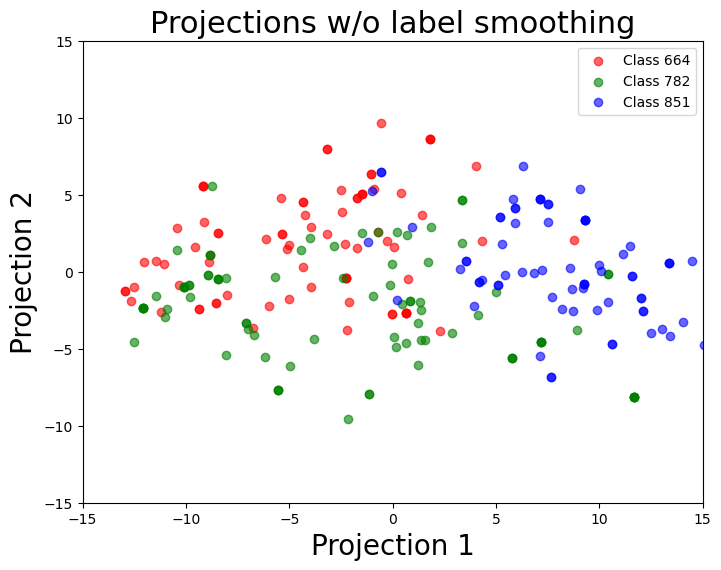

In [46]:
save_path = f'/home/hengl/lbsm/vis/rebuttals/{focus_classes[1]}_nols' + f'_{pre_fix}' + '.pdf'
plot_class_projections(projections_nols, labels_nols, post_fix='w/o label smoothing', save_path=save_path)


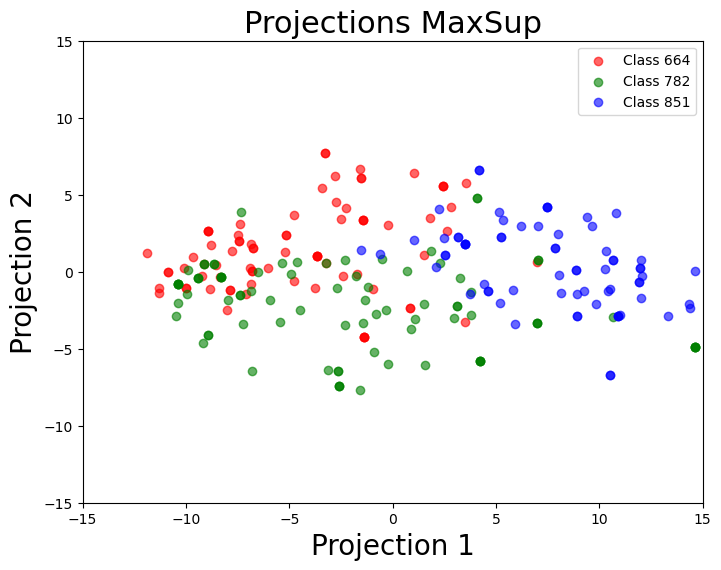

In [47]:
save_path = f'/home/hengl/lbsm/vis/rebuttals/{focus_classes[1]}_maxsup' + f'_{pre_fix}' + '.pdf'
plot_class_projections(projections_our, labels_our, post_fix='MaxSup', save_path=save_path)


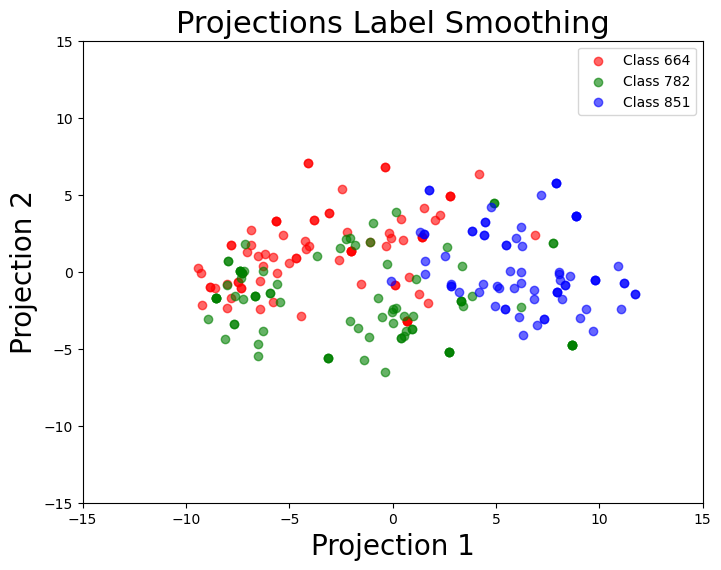

In [48]:
save_path = f'/home/hengl/lbsm/vis/rebuttals/{focus_classes[1]}_ls' + f'_{pre_fix}' +'.pdf'
plot_class_projections(projections_pretrained, labels_pretrained, post_fix='Label Smoothing',save_path=save_path)

- 617 不错
- 68 用我们的 top3 还行
- 用不同 top3 的区别是什么?
- 用我们的总是好一些
- 感觉可以画个动图, 随着训练来

In [49]:
from plot import plot_decision_boundary1
x_lim = (-15, 15)
y_lim = (-20, 10)

In [50]:
plot_decision_boundary1(our_clf, X_2, projections_our, labels_our, post_fix='ours', highlight_miss=True,
                        x_lim=x_lim, y_lim=y_lim, show_legend=True, legend_position='inside', show_title=False, save_path=save_path)


NameError: name 'our_clf' is not defined

Train Accuracy: 0.6510
Test Accuracy: 0.7708
Voronoi test accuracy: 0.62
Unique classes: [66 67 68]
Correct indices: [False False False False False False False False False False False False
 False False False False  True False False False False False False False
 False False False False False False False False  True False False False
 False False False False False False False False False False False False]


/home/hengl/lbsm/vis/plot.py:406: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter_background = ax.scatter(


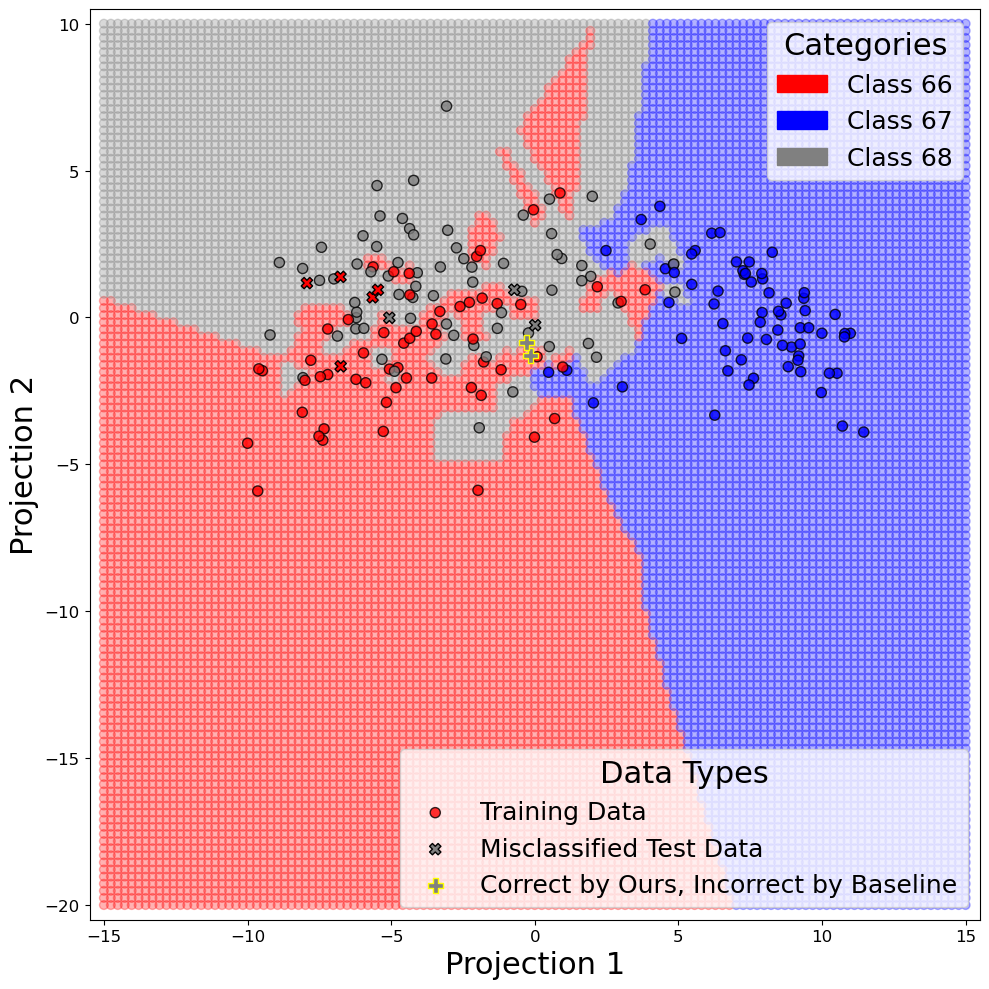

In [136]:
plot_decision_boundary1(pretrained_clf, X_1, projections_pretrained, labels_pretrained, 
                       x_lim=x_lim, y_lim=y_lim, post_fix='pretrained', 
                       highlight_miss=True, other_classifier=our_clf, other_features=X_2, legend_position='inside', save_path=save_path)

- 68, sample 0.4 结果还可以